# LBand vs agb

Use LBand to generate an estimated agb map with the wcm function

_time < 9min_

_Inputs: LBand, LNL_PlotDumps.txt_

## 1. Import modules

In [1]:
%matplotlib inline
import plant
import math
from os import path
import numpy as np
import pickle
import cartopy
from multiprocessing import Process, Manager

## 2. Global variables

In [2]:
from config import *

## 3. Crop and visualize LBand

In [3]:
_ = plant.mosaic(file_LHV_gamma_in, 
                 bbox=bbox, 
                 step_lat=step_lat, 
                 step_lon=step_lon, 
                 output_file=file_LHV_crop, 
                 **options)
_ = plant.mosaic(file_LHH_gamma_in, 
                 bbox=bbox, 
                 step_lat=step_lat, 
                 step_lon=step_lon, 
                 output_file=file_LHH_crop, 
                 **options)
_ = plant.mosaic(file_LVV_gamma_in, 
                 bbox=bbox, 
                 step_lat=step_lat, 
                 step_lon=step_lon, 
                 output_file=file_LVV_crop, 
                 **options)

PLAnT 0.1.04dev (API) - plant_display.py "/home/croce/ml/dat/lband/rtc/output/LHV.tiff" --db --label "LHV" "/home/croce/ml/dat/lband/rtc/output/LHH.tiff" --db --label "LHH" "/home/croce/ml/dat/lband/rtc/output/LVV.tiff" --db --label "LVV" --title "" --label-x "Backscatter [dB]" --no-grid --hist --legend-pos "upper left" --mute


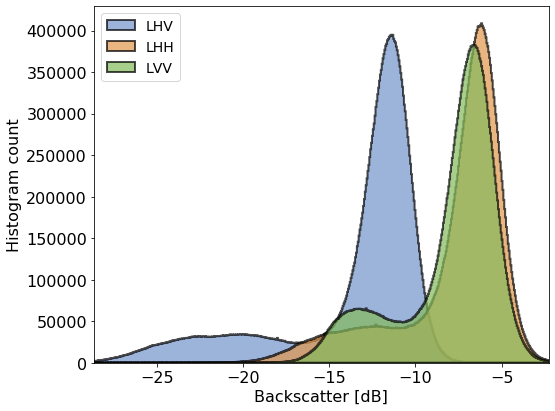

In [4]:
display_options_fit_str = ('--no-grid --hist --legend-pos "upper left" --mute')
_ = plant.execute(f'plant_display.py {file_LHV_crop} --db --label "LHV" {file_LHH_crop} --db --label "LHH" {file_LVV_crop} --db --label "LVV" --title "" --label-x "Backscatter [dB]" {display_options_fit_str}')

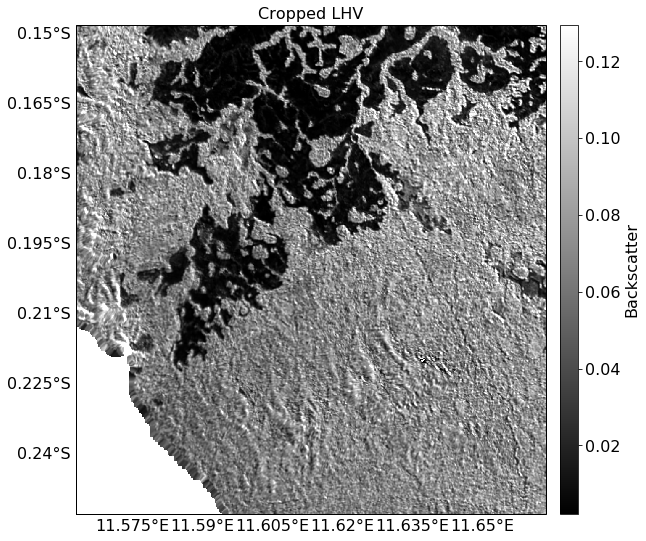

In [15]:
_ = plant.display(file_LHV_crop, label='Cropped LHV', plot_size_x=9, plot_size_y=9, label_x_rotation=45, cartopy=True, colorbar_label='Backscatter', **options)

## 4. Sample the field data for the agb

In [6]:
subplot_width_m = 40
subplot_width = subplot_width_m // 20

n_subplots = (5-(subplot_width-1))**2
n_plots = 12

In [7]:
field_options = dict(options)
field_options['subplot_width'] = subplot_width_m
field_options['ref'] = tdt_ref
field_options['first_line'] = 2
field_options['separator'] = 'TAB'
field_options['save_as_raster_gdal'] = True
field_options['step'] = 0.000001
field_options['chave2014_E'] = e_file
field_options['force'] = True
field_options['output_skip_if_existent'] = True

manager = Manager()
agb_shared = manager.dict()

def create_agb_shared(plot_start, plot_end):
    for subplot in range(1, n_subplots + 1):
        field_options['subplot_id'] = subplot
        for plot in range(plot_start, plot_end):
            print(f'processing subplot {subplot} field plot {plot}...')
            plot_number = f'{plot:02}'
            input_file = path.join(tdt_dir, f'LNL_{plot_number}_PlotDump.txt')
            output_file = path.join(field_output_dir, f'plot_{plot_number}/plot_{plot_number}_s{subplot}')
            try:
                plant.agb_samples(input_file,
                                  output_file=output_file, 
                                  **field_options)
                agb_shared[subplot - 1, plot - 1] = plant.plant_info(output_file + '_agb_plot_ha.bin', mean=True, **options).image[0]
            except: 
                agb_shared[subplot - 1, plot - 1] = [np.nan]
                print('    not enough points')
                
base_plots_pp = math.floor(n_plots / N_PROCESSES)
remainder_pp = n_plots % N_PROCESSES
offset_pp = 0
processes = list()

for i in range(N_PROCESSES):
    start_pl = (i*base_plots_pp) + offset_pp + 1
    end_pl = start_pl + base_plots_pp + (1 if remainder_pp > 0 else 0)
    if remainder_pp > 0:
        remainder_pp -= 1
        offset_pp += 1
    p = Process(target=create_agb_shared, args=(start_pl, end_pl))
    p.start()
    processes.append(p)
for p in processes:
        p.join()

agb_dict = dict(agb_shared)
agb_vect = np.full((n_subplots, n_plots), np.nan)
for item in agb_dict.items():
    agb_vect[item[0]] = item[1][0]
pickle.dump(agb_vect, open(file_agb_vector, "+wb"))
print('')
print('######## DONE ########')

processing subplot 1 field plot 1...
processing subplot 1 field plot 4...
processing subplot 1 field plot 7...
processing subplot 1 field plot 10...
processing subplot 1 field plot 2...
processing subplot 1 field plot 8...
processing subplot 1 field plot 11...
processing subplot 1 field plot 5...
processing subplot 1 field plot 3...
processing subplot 1 field plot 12...
processing subplot 1 field plot 9...
processing subplot 1 field plot 6...
processing subplot 2 field plot 10...
processing subplot 2 field plot 7...
processing subplot 2 field plot 1...
processing subplot 2 field plot 4...
processing subplot 2 field plot 2...
processing subplot 2 field plot 11...
processing subplot 2 field plot 8...
processing subplot 2 field plot 5...
processing subplot 2 field plot 3...
processing subplot 2 field plot 12...
processing subplot 2 field plot 6...
processing subplot 2 field plot 9...
processing subplot 3 field plot 1...
processing subplot 3 field plot 10...
processing subplot 3 field plot

## 5. Colocate the LBand with the field data

In [8]:
manager = Manager()
mean_LHV_shared = manager.dict()

def create_LHV_shared(plot_start, plot_end):
    for subplot in range(1, n_subplots + 1):
        for plot in range(plot_start, plot_end):
            if plant.isnan(agb_vect[subplot - 1, plot - 1]):
                print(f'sublot {subplot} field plot {plot} is NaN')
                continue
            print(f'processing subplot {subplot} field plot {plot}...')
            plot_number = f'{(plot):02}'
            est_tree_height_file = path.join(field_output_dir,
                                             f'plot_{plot_number}/plot_{plot_number}_s{subplot}_tree_height_field_estimated.bin')   
            est_tree_height_radar_file_LHV = path.join(uavsar_output_dir,
                                                       f'plot_{plot_number}/plot_{plot_number}_s{subplot}_tree_height_field_radar_LHV.{output_ext}')
            plant.mosaic(file_LHV_crop,
                         bbox_file=est_tree_height_file,
                         output_file=est_tree_height_radar_file_LHV,
                         interp='average',
                         **options)
            plant.util(est_tree_height_radar_file_LHV,
                       output_file=est_tree_height_radar_file_LHV,
                       mask_less=0,
                       mask_ref=est_tree_height_file,
                       **options)
            mean_LHV_shared[subplot - 1, plot - 1] = plant.plant_info(est_tree_height_radar_file_LHV,
                                                                      data_mean=True,
                                                                      **options).image[0][0]

base_plots_pp = math.floor(n_plots / N_PROCESSES)
remainder_pp = n_plots % N_PROCESSES
offset_pp = 0
processes = list()

for i in range(N_PROCESSES):
    start_pl = (i*base_plots_pp) + offset_pp + 1
    end_pl = start_pl + base_plots_pp + (1 if remainder_pp > 0 else 0)
    if remainder_pp > 0:
        remainder_pp -= 1
        offset_pp += 1
    p = Process(target=create_LHV_shared, args=(start_pl, end_pl))
    p.start()
    processes.append(p)
for p in processes:
        p.join()

mean_LHV_dict = dict(mean_LHV_shared)
mean_LHV_vect = np.full((n_subplots, n_plots), np.nan)
for item in mean_LHV_dict.items():
    mean_LHV_vect[item[0]] = item[1]
LHV_vect_file = path.join(uavsar_output_dir, f'LHV_vect.{output_ext}')
agb_vect_file = path.join(field_output_dir, f'agb_vect.{output_ext}')

_ = plant.util(mean_LHV_vect, output_file=LHV_vect_file, **options)
_ = plant.util(agb_vect, output_file=agb_vect_file, mask_greater=450, mask_less=0, **options)

print('')
print('######## DONE ########')

processing subplot 1 field plot 1...
processing subplot 1 field plot 4...
processing subplot 1 field plot 7...
processing subplot 1 field plot 10...
processing subplot 1 field plot 2...
processing subplot 1 field plot 5...
processing subplot 1 field plot 11...
processing subplot 1 field plot 8...
processing subplot 1 field plot 3...
processing subplot 1 field plot 6...
processing subplot 1 field plot 12...
processing subplot 1 field plot 9...
processing subplot 2 field plot 1...
processing subplot 2 field plot 4...
processing subplot 2 field plot 10...
processing subplot 2 field plot 7...
processing subplot 2 field plot 2...
processing subplot 2 field plot 5...
processing subplot 2 field plot 8...
processing subplot 2 field plot 11...
processing subplot 2 field plot 3...
processing subplot 2 field plot 6...
processing subplot 2 field plot 9...
processing subplot 2 field plot 12...
processing subplot 3 field plot 4...
processing subplot 3 field plot 1...
processing subplot 3 field plot 

## 6. Fit and visualize the wcm function

PLAnT 0.1.04dev (API) - plant_display.py "/home/croce/ml/dat/field/output/agb_vect.tiff" "/home/croce/ml/dat/lband/rtc/output/LHV_vect.tiff" --db --function-fit "wcm_db" --out-function-fit "/home/croce/ml/dat/lband/rtc/coeffs/coeffs_wcm.bin" --title "" --first-image-as-x --label-y "LHV Backscatter [dB]" --label-x "Biomass [Mg/ha]" --force --marker-size "300" --scatterplot --mute


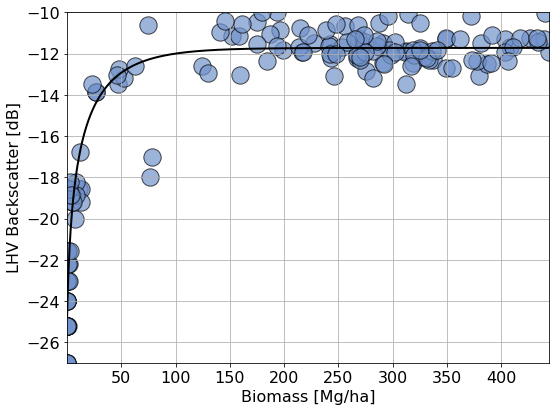

In [9]:
display_options_fit_str = (' --title "" --first-image-as-x --label-y "LHV Backscatter [dB]" --label-x "Biomass [Mg/ha]" --force --marker-size 300 --scatterplot --mute')

_ = plant.execute(f'plant_display.py {agb_vect_file} {LHV_vect_file} --db --function-fit wcm_db --out-function-fit {coeffs_file} {display_options_fit_str}')

In [10]:
coeffs_lband = plant.read_image(coeffs_file)
coeffs_lband_hv = coeffs_lband.image[0, :]
coeffs_lband_hv_str = ' '.join([str(c) for c in coeffs_lband_hv])
print('Coefficients: ', coeffs_lband_hv_str)

opening: /home/croce/ml/dat/lband/rtc/coeffs/coeffs_wcm.bin (GDAL: ENVI) 
Coefficients:  0.003292080105000669 0.0640026445053484 0.027374595889998455


## 7. Visualize the generated map

In [11]:
_ = plant.mosaic(file_LHV_crop,
                 output_file=file_LHV_40,
                 step_m=40,
                 interp='average',
                 **options)
_ = plant.util(file_LHV_40, 
               output_file=file_LHV_40, 
               db=True, 
               **options)

In [16]:
backscatter_100Mg = plant.util(100, evaluate='wcm_db '+coeffs_lband_hv_str, **options).image[0][0]
print("The backscatter at 100Mg/ha is:", backscatter_100Mg)
_ = plant.util(file_LHV_40, output_file=file_LHV_40, clip=[np.nan, backscatter_100Mg], **options)
_ = plant.util(file_LHV_40, output_file=map_file, evaluate='wcm_db_inv '+coeffs_lband_hv_str, **options)

The backscatter at 100Mg/ha is: -11.996160569943413


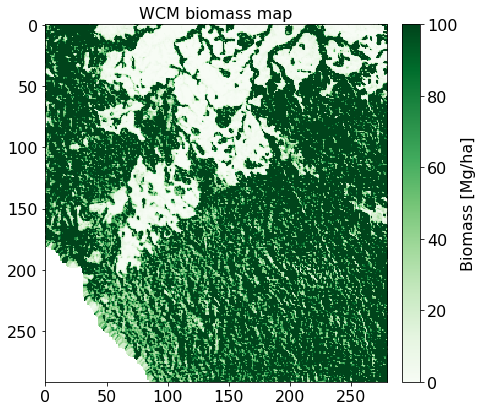

In [17]:
_ = plant.display(map_file, title='WCM biomass map', colorbar_label='Biomass [Mg/ha]', cmap='Greens', background_color='white', min=0, max=100, **options)

Share the results with the MAAP: LBand cropped, AGB vector, wcm coefficients, wcm agb map